In [2]:
%matplotlib inline
from helpers import *

# import 'Sequential' is a linear stack of neural network layers. Will be used to build the feed-forward CNN
from keras.models import Sequential 
# import the "core" layers from Keras (these are the most common layers)
from keras.layers import Dense, Dropout, Activation, Flatten
# import the convolutional layers that will help us efficiently train on image data
from keras.layers import Conv2D, MaxPooling2D
# these utilities will help us transform our data
from keras.utils import np_utils

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth, after discretizing by "discretizing" it patch-wise.

### - Load data

In [3]:
# Loaded a set of images
n = 20

imgs, gt_imgs = load_images(n)

imgs[0].shape, gt_imgs[0].shape

Loading 20 images


((400, 400, 3), (400, 400))

### - For now avoid cross validation, just split the datasest in test and train. 

In [5]:
train_ratio = 0.8
train, test = split_train_test(imgs, gt_imgs, train_ratio=train_ratio, seed=1)
train.imgs.shape, train.gt_imgs.shape, test.imgs.shape, test.gt_imgs.shape 

((16, 400, 400, 3), (16, 400, 400), (4, 400, 400, 3), (4, 400, 400))

### - Generate the inpus and the outputs
We reshape each input to fulfill the requirements of the tensorflow library. 

In [13]:
train.gt_imgs.shape

(16, 400, 400)

In [20]:
img_crop_matr(train.gt_imgs[0]).shape

(25, 25, 16, 16)

In [22]:
def gt_imgs_to_Y(gt_imgs):
    gt_matr = np.array([img_crop_matr(gt_img) for gt_img in gt_imgs])
    return [for gt_matr]
    
train.X = train.imgs
train.Y = gt_imgs_to_Y(train.gt_imgs)

test.X = test.imgs
test.Y = gt_imgs_to_Y(test.gt_imgs)
train.X.shape, train.Y.shape

((16, 400, 400, 3), (16, 25, 16, 16))

Recap on **train** (and test) object:
- **train.imgs**: (expanded) images of the training set. **shape**=(#train images, 400, 400, 3)
- **train.gt_imgs**: respective groundtruth images. **shape**=(#train images, 400, 400)
- **train.X**: inputs extracted from train.imgs. **shape**=(#total windows, 72, 72, 3)
- **train.Y**: outputs extracted from train.gt_imgs. **shape**=(#total windows, 2)

### - Build the CNN model

How to build the cnn model:
- **Convolutional layers**: Conv1D or **Conv2D** (1D: covolution over a single spatial dimension)
    - **filters**: 

In [24]:
nclasses = 2
model = Sequential()
# 32 convolution filters
# 5 rows in convolution kernel
# 5 columns in convolution kernel
# (1,28,28) is the shape of one input
# strides=(1, 1) by default (step size?)
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=train.X[0].shape))
model.add(Conv2D(32, (5, 5), activation='relu'))

# MaxPooling2D is a way to reduce the number of parameters in our model by sliding 
# a 2x2 pooling filter across the previous layer and taking the max of the 4 values 
# in the 2x2 filter.
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) # a method for regularizing our model in order to prevent overfitting.

# a convolutional neural network always ends with a fully connected layer followe by the ouput
# layer
# first flatten the weights of the convolution
model.add(Flatten())
# 128 = output size of the dense layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
# 2 = output size of the output dense layer (we have 2 classes)
model.add(Dense(nclasses, activation='softmax'))
Dense

model.output_shape

(None, 2)

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### - Fit the model on the train data

In [26]:
model.fit(train.X, train.Y, batch_size=32, epochs=2, verbose=1)

AttributeError: 'Sequential' object has no attribute 'summarize'

### - Evaluate the model on the test data

In [ ]:
# score = model.evaluate(test.X, test.Y, verbose=1)
# score

In [43]:
Z = model.predict_classes(test.X, verbose=1)
stats(Z, test.Y[:, 1])

2500/2500 [==============================] - 33s 13ms/step


actual (Y)         
                0 (background) 1 (road)
predicted (Z) 0           1600      282
              1            160      458

actual (Y)          
                0 (background)  1 (road)
predicted (Z) 0       0.909091  0.381081
              1       0.090909  0.618919


Recall = 0.618918918919
Precision = 0.741100323625
F1 = 0.674521354934


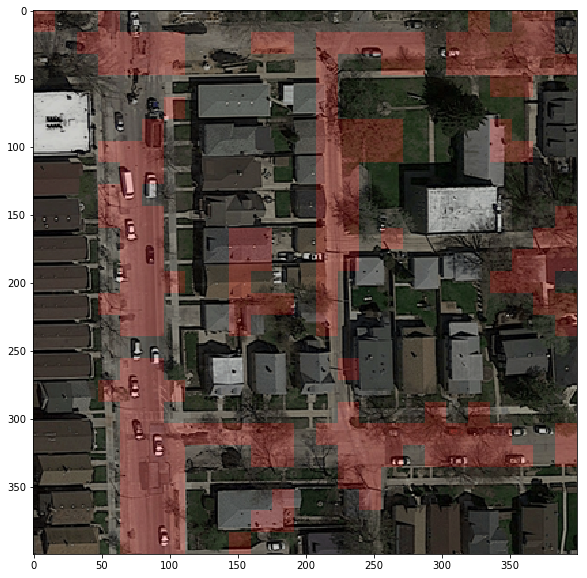

In [44]:
i = 0
display_ith_prediction(test, Z, i, window_width)

**problem**: it predicts always the same class [check here](https://stackoverflow.com/questions/41488279/neural-network-always-predicts-the-same-class)